## 1.1 Setup Import Libs
We will import sklearn models as needed

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Helpers

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6


## 1.2 Setup helper Functions
There is no need to understand this code. Just run it to simplify the code later in the tutorial.


In [ ]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 1.3 Import data
Now that our packages are loaded, let's read in and take a peek at the data.


In [109]:
# get titanic & test csv files as a DataFrame
titanic = pd.read_csv("data/train.csv")
test    = pd.read_csv("data/test.csv")

full = titanic.append( test , ignore_index = True )

print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


## 2.1 Getting to know the data

To understand the data we are now going to consider some key facts about various variables including their relationship with the target variable, i.e. survival.

We start by looking at a few lines of the data


In [106]:
# Run the code to see the variables, then read the variable description below to understand them.
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


**VARIABLE DESCRIPTIONS:**

We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:


**Variable Description**

 - Survived: Survived (1) or died (0)
 - Pclass: Passenger's class
 - Name: Passenger's name
 - Sex: Passenger's sex
 - Age: Passenger's age
 - SibSp: Number of siblings/spouses aboard
 - Parch: Number of parents/children aboard
 - Ticket: Ticket number
 - Fare: Fare
 - Cabin: Cabin
 - Embarked: Port of embarkation


### 2.2 Next have a look at some key information about the variables
An numeric variable is one with values of integers or real numbers while a categorical variable is a variable that can take on one of a limited, and usually fixed, number of possible values, such as blood type.

Notice especially what type of variable each is, how many observations there are and some of the variable values.

An interesting observation could for example be the minimum age 0.42, do you know why this is?

*Select the cell below and run it by pressing the play button.*

In [ ]:
titanic.describe()

In [ ]:
titanic.describe(include=['O'])

### 2.3 Data Exploration
PLot correlations

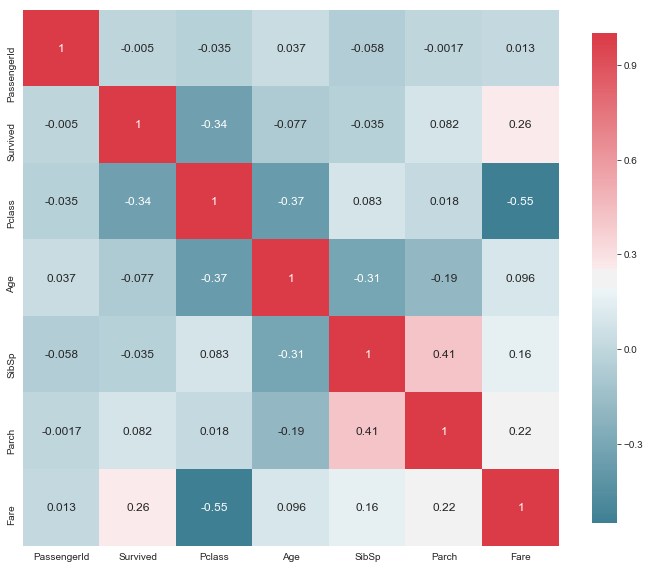

In [108]:
plot_correlation_map( titanic )

Correlations are not the whole story as it only picks up linear dependencies 

### 2.3.1 Let's further explore the relationship between the features and survival of passengers 
We start by looking at the relationship between age and survival.

*Select the cell below and run it by pressing the play button.*

In [ ]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Age' , target = 'Survived', row='Sex')

Consider the graphs above. Differences between survival for different values is what will be used to separate the target variable (survival in this case) in the model. If the two lines had been about the same, then it would not have been a good variable for our predictive model. 

Consider some key questions such as; what age does males/females have a higher or lower probability of survival? 

### 2.3.2 Excersise 1: Investigating the other numeric variables
It's time to get your hands dirty and do some coding! Try to plot the distributions of Fare of passangers who survived or did not survive. Then consider if this could be a good predictive variable.

*Hint: use the code from the previous cell as a starting point.*

In [ ]:
# In the this cell plot distributions of Fare of passangers who survived or did not survive


### 2.4.4 Embarked
We can also look at categorical variables like sex and their relationship with survival.



In [ ]:
titanic[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().sort_values(by='Survived', ascending=False)


### Investigate other categorical variables
Pclass, SibSp, Embarked and Parch


In [ ]:
# Embarked


In [ ]:
# Pclass

In [ ]:
# Parch

In [ ]:
# SibSp

# 3. Data Preparation

## 3.1 Categorical variables need to be transformed to numeric variables
The variables *Embarked*, *Pclass* and *Sex* are treated as categorical variables. Some of our model algorithms can only handle numeric values and so we need to create a new variable (dummy variable) for every unique value of the categorical variables.

This variable will have a value 1 if the row has a particular value and a value 0 if not. *Sex* is a dichotomy (old school gender theory) and will be encoded as one binary variable (0 or 1).

*Select the cells below and run it by pressing the play button.*

In [ ]:
# Transform Sex into binary values 0 and 1
def prepSex(df):
    return pd.Series( np.where( full.Sex == 'male' , 1 , 0 ), name = 'Sex' )
sex = prepSex(full)
sex


In [ ]:
# Create a new variable for every unique value of Embarked (binary encoding)
# hint look at the pandas.get_dummies method
def prepEmbarked(df):
    return pd.get_dummies(df.Embarked, prefix='Embarked_')
    pass
embarked = prepEmbarked(full)

In [ ]:
# Create a new variable for every unique value of Pclass (binary encoding)
# hint look at the pandas.get_dummies method
def prepPclass(df):
    return pd.get_dummies(df.Pclass, prefix='Pclass_')
    pass


## 3.2 Fill missing values in variables (Data Imputation)
Most machine learning alghorims require all variables to have values in order to use it for training the model. The simplest method is to fill missing values with the average of the variable across all observations in the training set.


In [ ]:

# hint use the pandas fillna method 
def imputeAgeViaMean(df):
    return df['Age'].fillna(df.Age.mean())
    pass
#     
# full['imputedAge'] = imputeAgeViaMean(full)
# full[['imputedAge', 'Age']]

# imputed = pd.DataFrame()
def imputeFareViaMean(df):
    return df['Fare'].fillna(df.Fare.mean())
    pass
# # Fill missing values of Age with the average of Age (mean)
# imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# # Fill missing values of Fare with the average of Fare (mean)
# imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

# imputed.head()

## 3.3 Feature Engineering &ndash; Creating new variables
Credit: http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

### 3.3.1 Extract titles from passenger names
Titles reflect social status and may predict survival probability

*Select the cell below and run it by pressing the play button.*

In [ ]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

# create a function that extracts the title from name and return pd.Series of titles
def extractTitle(df):
    return pd.Series(full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() ), name='Title')
    pass

title = extractTitle(full)
title.value_counts()

# we map each title
# title[ 'Title' ] = title.Title.map( Title_Dictionary )
# title = pd.get_dummies( title.Title )
# #title = pd.concat( [ title , titles_dummies ] , axis = 1 )

# title.head()

In [ ]:
pd.concat([title, embarked], axis=1)

In [104]:
def prepTitle(df):
    # hint https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html with Title_Dictionary
    title = extractTitle(df)
    title = title.map(Title_Dictionary)
    return pd.get_dummies(title, prefix='Title_')
    pass

# title = pd.Series(full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() ), name='Title')



# a map of more aggregated titles

### 3.3.2 Extract Cabin category information from the Cabin number

*Select the cell below and run it by pressing the play button.*

In [ ]:
# come back to this later if you want to see if you can make further improvements to the model 
def prepCabin(df):
    pass
# cabin = pd.DataFrame()

# # replacing missing cabins with U (for Uknown)
# cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# # mapping each Cabin value with the cabin letter
# cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# # dummy encoding ...
# cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

# cabin.head()

### 3.3.3 Extract ticket class from ticket number

*Select the cell below and run it by pressing the play button.*

In [ ]:
# come back to this later if you want to see if you can make further improvements to the model 
def prepTicket(df):
    pass
# def cleanTicket( ticket ):
#     ticket = ticket.replace( '.' , '' )
#     ticket = ticket.replace( '/' , '' )
#     ticket = ticket.split()
#     ticket = map( lambda t : t.strip() , ticket )
#     ticket = list(filter( lambda t : not t.isdigit() , ticket ))
#     if len( ticket ) > 0:
#         return ticket[0]
#     else: 
#         return 'XXX'

# ticket = pd.DataFrame()

# # Extracting dummy variables from tickets:
# ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
# ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

# ticket.shape
# ticket.head()

### 3.3.4 Create family size and category for family size
The two variables *Parch* and *SibSp* are used to create the famiy size variable

*Select the cell below and run it by pressing the play button.*

In [ ]:
# make a function that extracts family size as a pd.Series, a family size of 1  should indicate the individual is on their own
def familySize(df):
#     pass
    return full[ 'Parch' ] + full[ 'SibSp' ] + 1

# make a function that extracts returns 3 pd.Series ta t are binary feautres signalling whether an individual 
def prepFamilyFeatures(df):
    family = familySize(df)
    familyFrame = pd.DataFrame()
    familyFrame['Family_Single'] = family.map(lambda s : 1 if s == 1 else 0)
    familyFrame['Family_Small'] = family.map(lambda s : 1 if 2 <= s <= 4 else 0)
    familyFrame['Family_Large'] = family.map(lambda s : 1 if 5 <= s else 0)
    return familyFrame
    pass
familyFeatures = prepFamilyFeatures(full)


familyFeatures

## 3.4 Assemble final datasets for modelling

Split dataset by rows into test and train in order to have a holdout set to do model evaluation on. The dataset is also split by columns in a matrix (X) containing the input data and a vector (y) containing the target (or labels).

### 3.4.1 Variable selection
Select which features/variables to inculde in the dataset from the list below:

 - age
 - embarked
 - pclass
 - sex
 - family
 - cabin
 - ticket

*Include the variables you would like to use in the function below seperated by comma, then run the cell*

In [164]:
# Select which features/variables to include in the dataset from the list below:
# imputed fare and age, embarked features, pclass , sex , family featrues, cabin , ticket
def prepData(df):
    return pd.concat([prepTitle(df),
                      prepFamilyFeatures(df),
                      imputeFareViaMean(df),
                      imputeAgeViaMean(df),
                      prepPclass(df),
                      prepEmbarked(df),
                      prepSex(df)
                     ], axis=1)
full_X = prepData(full)
full_y = full.Survived


### 3.4.2 Create datasets
Below we will seperate the data into training and test datasets.

*Select the cell below and run it by pressing the play button.*

In [165]:
# Create all datasets that are necessary to train, validate and test models
train_X_full = full_X[ 0:891 ]
train_y_full = full_y[ 0:891 ]
test_X = full_X[ 891: ]
test_y = full_y[ 891: ]

print (train_X.shape , train_y.shape , test_X.shape , test_y.shape)

train_X , valid_X , train_y , valid_y = train_test_split( train_X_full , train_y_full , train_size = .7 )



print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(623, 18) (623,) (418, 18) (418,)
(1309, 18) (623, 18) (268, 18) (623,) (268,) (418, 18)


### 3.4.3 Feature importance
Selecting the optimal features in the model is important. 
We will now try to evaluate what the most important variables are for the model to make the prediction.

*Select the cell below and run it by pressing the play button.*

0.9842873176206509


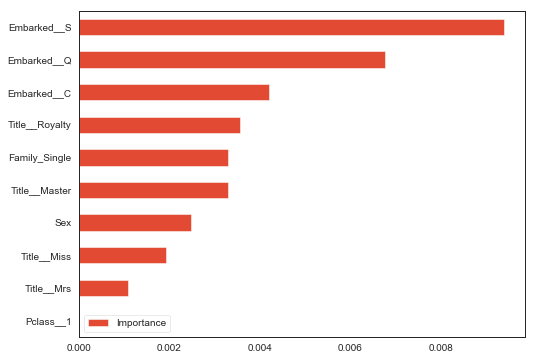

In [130]:
plot_variable_importance(train_X, train_y)

# 4. Modeling
We will now select a model we would like to try then use the training dataset to train this model and thereby check the performance of the model using the test set. 

## 4.1 Model Selection
Then there are several options to choose from when it comes to models. A good starting point is RandomForestClassifier. 

**Select the model you would like to try below and run the corresponding cell by pressing the play button.**

In [150]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import f1_score

### 4.1.1 Random Forests Model
Try a random forest model by running the cell below. 

In [166]:
model = RandomForestClassifier(n_estimators=100)

### 4.1.2 Support Vector Machines
Try a Support Vector Machines model by running the cell below. 

In [ ]:
model = SVC()

### 4.1.3 Gradient Boosting Classifier
Try a Gradient Boosting Classifier model by running the cell below. 

In [ ]:
model = GradientBoostingClassifier()

### 4.1.4 K-nearest neighbors
Try a k-nearest neighbors model by running the cell below. 

In [ ]:
model = KNeighborsClassifier(n_neighbors = 3)

### 4.1.5 Gaussian Naive Bayes
Try a Gaussian Naive Bayes model by running the cell below. 

In [ ]:
model = GaussianNB()

### 4.1.6 Logistic Regression
Try a Logistic Regression model by running the cell below. 

In [116]:
model = LogisticRegression()

## 4.2 Train the selected model
When you have selected a dataset with the features you want and a model you would like to try it is now time to train the model. After all our preparation model training is simply done with the one line below.

*Select the cell below and run it by pressing the play button.*

In [167]:
model.fit( train_X , train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# 5. Evaluation
Now we are going to evaluate model performance and the feature importance.

## 5.1 Model performance

We then compare this accuracy score with the accuracy when using the model on the training data. If the difference between these are significant this is an indication of overfitting. We try to avoid this because it means the model will not generalize well to new data and is expected to perform poorly.

*Select the cell below and run it by pressing the play button.*

In [168]:
# Score the model for accuracy
print (model.score( train_X , train_y ) , model.score( test_X , test_y ))
# score model for f1
print(f1_score(train_y, model.predict(train_X)), f1_score(test_y, model.predict(test_X)))

0.9871589085072231 0.8205741626794258
0.9829787234042553 0.7588424437299035


## 5.2 Feature importance - selecting the optimal features in the model
We will now try to evaluate what the most important variables are for the model to make the prediction. The function below will only work for decision trees, so if that's the model you chose you can uncomment the code below (remove # in the beginning)  and see the feature importance.

*Select the cell below and run it by pressing the play button.*

0.9903691813804173


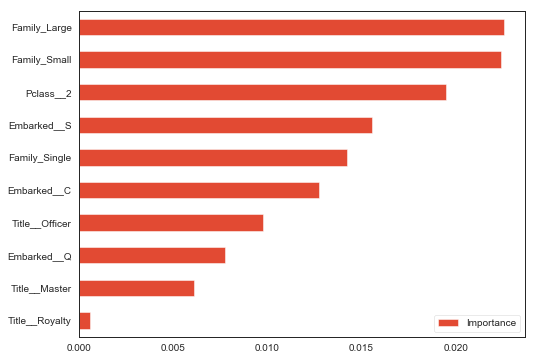

In [153]:
plot_model_var_imp(model, train_X, train_y)

### 5.2.1 Automagic
It's also possible to automatically select the optimal number of features and visualize this. 

*Select the cell below and run it by pressing the play button.*

0.8282504012841091 0.8432835820895522
Optimal number of features : 7


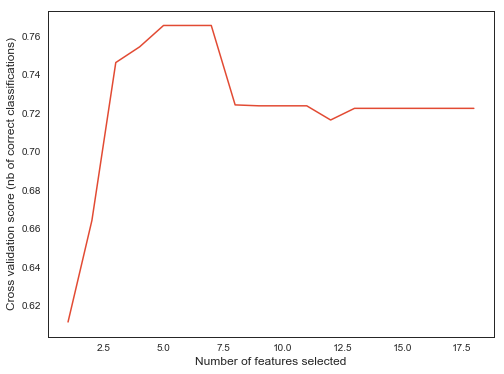

In [234]:
rfecv = RFECV( estimator = model , step = 1 , cv = StratifiedKFold( train_y , 2 ) , scoring = 'f1' )
rfecv.fit( train_X , train_y )

print (rfecv.score( train_X , train_y ) , rfecv.score( valid_X , valid_y ))
print( "Optimal number of features : %d" % rfecv.n_features_ )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (nb of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()

# shit, doesnt work well


### Hyper-Parameter tuning
Most ML models have parameters that can be tuned to give better performance. For example logistic regression has regularisation coefient C, which can be adjusted to prevent overfitting. Lower C values -> more regularisation

In [227]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': [0.01,0.05, 0.1, 0.5, 1, 5, 10, 100], 'penalty': ['l1', 'l2']}
model_in = LogisticRegression()
# reduced_x = train_X_full[['Family_Small', 'Family_Large', 'Pclass__2', 'Embarked__S', 'Family_Single', 'Embarked__C']]
grid = GridSearchCV(model_in, param_grid=parameters, cv=2)
grid.fit(train_X_full, train_y_full)
best_model = grid.best_estimator_
print(best_model.get_params())
print(grid.best_score_)

{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.819304152637486


In [229]:
model = LogisticRegression(**best_model.get_params())
model.fit(train_X_full.astype('float'), train_y_full)
print(model.score(train_X_full, train_y_full ), model.score( test_X , test_y ))
print(f1_score(train_y_full, model.predict(train_X_full)), f1_score(test_y, model.predict(test_X)))

0.8282828282828283 0.9425837320574163
0.7685325264750379 0.9245283018867926


In [233]:
model.predict(train_X_full)
train_y_full.as_matrix()

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

## 5.3 Competition time!
Who can build the model that gives the highest F1 score? Make imporvements in anyway you want.

Test a bunch of different model and see which ones work best.

Perform more hyper-parameter tuning on models.

Maybe adding a ticket and cabin features will help you out .

Reduce the number of features you use, this may help with overfitting. 

Many of the kaggle competition winners use an emsemble of models see (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) for more information on what I mean by that